In [35]:
import hist
import dask
import awkward as ak
import hist.dask as hda
import dask_awkward as dak
import numpy as np

from coffea import processor
from coffea.nanoevents.methods import candidate
from coffea.nanoevents.methods import vector as vec
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)
from distributed import Client
client = Client("tls://localhost:8786")


class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events):
        dataset = events.metadata['dataset']
        #print(events.fields)
        #event level cuts
        # apply trigger selection: `HLT_Ele115_CaloIdVT_GsfTrkIdT` OT `HLT_Photon200`
        # Electron.mvaNoIso_WP90 > 0 AND nElectron >= 2
        #event_check = events
        trigger_nelectron = (events.HLT_Ele115_CaloIdVT_GsfTrkIdT | events.HLT_Photon200) & (events.nElectron >= 2)
        events = events[trigger_nelectron]
        electrons = ak.zip(
            {
                "pt": events.Electron_pt,
                "eta": events.Electron_eta,
                "phi": events.Electron_phi,
                "mass": events.Electron_mass,
                "charge": events.Electron_charge,
                "dz": events.Electron_dz,
                "mvaNoIso_WP80": events.Electron_mvaNoIso_WP80,
                "mvaNoIso_WP90": events.Electron_mvaNoIso_WP90,
                "nElectron": events.nElectron,
                "superclusterEta": events.Electron_superclusterEta,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )

        cut_mva = (electrons.mvaNoIso_WP90 > 0) 
        ele2 = electrons[cut_mva]
        #check---------------------------------------
        ele2_check = ele2
        ###############################################
        #ECAL transition region: 1.44 < |η| < 1.57 that should be vetoed
        abs_sc_eta = np.abs(ele2.superclusterEta)
        eta_trasition_cut = (abs_sc_eta > 1.44) & (abs_sc_eta < 1.57)
        ele2 = ele2[~eta_trasition_cut]
        #check------------------------
        ele2_after_eta_trasition_cut_check = ele2
        ##########################################################
        #tag
        # pt > 120 GeV AND ak.abs(eta) < 2.5  AND Electron.dz < 0.1 (0.2) cm for Barrel (endcap).
        # barrel ( |eta supercluster| <= 1.479)
        # endcap ( |eta supercluster| > 1.479)
        # Tight MVA ID: Electron.mvaNoIso_WP80 > 0

        is_barrel = (np.abs(ele2.superclusterEta) <= 1.479)
        is_endcap = (np.abs(ele2.superclusterEta) > 1.479) 
        pt_tag_cut  = (ele2.pt > 120)
        abs_superclusterEta_tag_cut= (np.abs(ele2.superclusterEta) < 2.5)
        
        dz_tag_cut  = ak.where(is_barrel, ele2.dz < 0.10, ele2.dz < 0.20)
        tight_mva_cut = (ele2.mvaNoIso_WP80 > 0)
        
        tag_cut = pt_tag_cut & abs_superclusterEta_tag_cut & dz_tag_cut & tight_mva_cut
        e_tag = ele2[tag_cut]
        
        not_tag_e_tagcut = ele2[~tag_cut] # e not passing tagging condition

        #clean up all lists: only events with at least one tag electron remain
        has_tag = ak.num(e_tag) > 0
        e_tag = e_tag[has_tag]
        ele2 = ele2[has_tag]
        not_tag_e_tagcut = not_tag_e_tagcut[has_tag]
        events = events[has_tag] 
        #update list, so that for the new events list, each of them have tag e (at least one)
        #print(events.fields)
        #check-----------------------------------
        e_tag_check = e_tag
        not_tag_e_tagcut_check = not_tag_e_tagcut
        
        ##########################################################
        #match trigger obj
        
        trig_e = ak.zip(
            {
                "pt": events.TrigObj_pt,
                "eta": events.TrigObj_eta,
                "phi": events.TrigObj_phi,
                "mass": ak.zeros_like(events.TrigObj_pt),
                "id": events.TrigObj_id,
                "filterBits": events.TrigObj_filterBits,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )

        #(events.TrigObj.id == 11) & ((events.TrigObj.filterBits & (1 << 12)) != 0 OR (events.TrigObj.filterBits & (1 << 14)) != 0)
        a = (trig_e.id == 11)
        b = (trig_e.filterBits & (1 << 12)) != 0
        c = (trig_e.filterBits & (1 << 14)) != 0
        trig_obj_cut= a & (b | c)
        trig_electrons = trig_e[trig_obj_cut]
        
        #check if the electron and trigger obj dR matches (if more than 1 tagged e find the one that matches with the trigger obj)
        # Build (electron info), (trigger obj) pairs for every event
        # next want to calculated the delta R between electron and trigger obj
        # when delta R is small, so they match, then this e should be the tag e

        pairs_e_trigObj = ak.cartesian(
            {"e_info": e_tag, "trig_obj": trig_electrons}, axis=1, nested=True
        )
        dR = pairs_e_trigObj.e_info.delta_r(pairs_e_trigObj.trig_obj)
        match_cut = ak.any(dR < 0.1, axis=2)
        e_tag_matched = e_tag[match_cut]
        
        
        not_tag_e_trigObj = e_tag[~match_cut] # e passes tagging condition but not trigObj
        
        keep_evt = ak.num(e_tag_matched) > 0
        events = events[keep_evt]
        e_tag_matched = e_tag_matched[keep_evt] 
        ele2 = ele2[keep_evt]
        e_tag = e_tag[keep_evt]
        not_tag_e_tagcut = not_tag_e_tagcut[keep_evt]
        not_tag_e_trigObj = not_tag_e_trigObj[keep_evt]
        probe_cand = ak.concatenate([not_tag_e_tagcut, not_tag_e_trigObj], axis=1)
        #check----------------------------------
        e_tag_matched_check = e_tag_matched
        probe_cand_check = probe_cand
        
        # update the event/electron list again, now only have events w/ tagged e
        # we have the tagged list and probe_cand list now
        ####################################################
        # now get probe e: pt > 10 GeV AND ak.abs(eta) < 2.5 
        probe_cut = (probe_cand.pt > 10) & (np.abs(probe_cand.superclusterEta) < 2.5)
        probe = probe_cand[probe_cut]
        #check----------------------------------
        probe_check = probe
        ####################################################
        # build the tag-probe pair and test which is within the z mass window
        #!!!!!!!!!!!!!z mass window need to check
        tp_pairs = ak.cartesian({"tag": e_tag_matched, "probe": probe}, axis=1, nested=True)
        p_mu_tot = tp_pairs.tag + tp_pairs.probe
        mass_constructed = p_mu_tot.mass
        z_win = (mass_constructed > 70.0) & (mass_constructed < 110.0)
        good_pairs = tp_pairs[z_win]
        ########################################################
        #the pairs are ready, now we want to see the tag & probe charge
        print("good")
        

        #get different situations of charge
        q_tag   = good_pairs.tag.charge
        q_probe = good_pairs.probe.charge
        
        both_pos = (q_tag > 0) & (q_probe > 0)    
        both_neg = (q_tag < 0) & (q_probe < 0)    
        mixed    = ((q_tag > 0) & (q_probe < 0)) | ((q_tag < 0) & (q_probe > 0))  
        
        n_pp = ak.sum(both_pos)
        n_mm = ak.sum(both_neg)
        n_pm = ak.sum(mixed)
        #n_entries = ak.num(good_pairs.tag, axis=0)
        n_entries=1000000 ###default, will use when needed
        #print("tag and prob")
        #print(n_pp, n_mm, n_pm, n_entries)
        #change the objects to int
        #n_pp, n_mm, n_pm, n_entries = dask.compute(n_pp, n_mm, n_pm, n_entries)
        #print("++:", n_pp)
        #print("--:", n_mm)
        #print("+-:", n_pm)
        #print("all",n_entries)
        ############################## Note: I did not cut the empty elements in the good_pair list, update it if needed 
        
        tag=good_pairs.tag
        probe=good_pairs.probe
        

    
        return {
                #"entries": n_entries,
                "tags": tag,
                "probes": probe,
                "num_pp": n_pp,  
                "num_mm": n_mm,  
                "num_pm": n_pm,
                #"event_check": event_check,
                "ele2_check": ele2_check,
                "e_tag_check": e_tag_check,
                "not_tag_e_tagcut_check": not_tag_e_tagcut_check,
                "e_tag_matched_check": e_tag_matched_check,  
                "probe_cand_check": probe_cand_check,  
                "probe_check": probe_check,
                "ele2_after_eta_trasition_cut_check": ele2_after_eta_trasition_cut_check,
                
                #"charge": hist,
    }

    def postprocess(self, accumulator):
        pass

In [ ]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)
fileset = {
    'DY_MC': {
        "files": {
            'root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-100to200_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v2/100000/29f004ec-99e8-41e6-b02e-39b07294ab06.root': "Events",
            'root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-200to400_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v2/100000/aaac973d-7645-471e-85de-72ebf34015f0.root': "Events",
            'root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-400to600_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v2/2810000/94f7ccff-b6b5-4036-a599-a8e1b2307afb.root': "Events",
            'root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-400to600_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v2/2810000/a1eb4ac9-17ea-4119-9a67-16c030de773c.root': "Events",
            'root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-40to100_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v3/100000/18197ca8-14a7-4705-acc3-5fbea17f890d.root': "Events",
            'root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-40to100_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v3/100000/185ba806-afd7-4a8b-9235-6e197fd618fc.root': "Events",
            'root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-40to100_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v3/100000/18bc8d9e-aaf7-45db-918f-8a5f93af48c7.root': "Events",
            'root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-600_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v2/100000/42992f08-f719-4c8f-8d98-7f9588942ca8.root': "Events",
            'root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-600_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v2/2520000/8e732505-eeea-45fa-b946-4147fdd1cc35.root': "Events",
            #'root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYJetsToLL_M-50_TuneCP5_13p6TeV-madgraphMLM-pythia8/NANOAODSIM/Pilot2024wmLHEGS_150X_mcRun3_2024_realistic_v1-v2/2540000/8908b7ad-b7b7-400c-8c4d-a859666fe8e2.root':"Events",
        }
    }
}


dataset_runnable, dataset_updated = preprocess(
    fileset,
    align_clusters=False,
    step_size=100_000,
    files_per_batch=1,
    skip_bad_files=True,
    save_form=False,
)

to_compute = apply_to_fileset(
                MyProcessor(),
                dataset_runnable,
                schemaclass=BaseSchema,
            )
(out,) = dask.compute(to_compute)
ds = out["DY_MC"]  


#print("++ rows:", out["DY_MC"]["num_pp"])
#print("-- rows:", out["DY_MC"]["num_mm"])
#print("+- rows:", out["DY_MC"]["num_pm"])


In [37]:
'''
1st plot:
After event level cut: apply trigger selection: `HLT_Ele115_CaloIdVT_GsfTrkIdT` OT `HLT_Photon200`
Electron.mvaNoIso_WP90 > 0 AND nElectron >= 2
ele2_check 

2nd plot:
After the transition religion cut
ECAL transition region: 1.44 < |η| < 1.57 that should be vetoed
ele2_after_eta_trasition_cut_check

3rd/4th plot:
After general tag selection: # pt > 120 GeV AND ak.abs(eta) < 2.5  AND Electron.dz < 0.1 (0.2) cm for Barrel (endcap).
        # barrel ( |eta supercluster| <= 1.479)
        # endcap ( |eta supercluster| > 1.479)
        # Tight MVA ID: Electron.mvaNoIso_WP80 > 0
e_tag_check
not_tag_e_tagcut_check

5th/6th plot
After trigger matching 
#(events.TrigObj.id == 11) & ((events.TrigObj.filterBits & (1 << 12)) != 0 OR (events.TrigObj.filterBits & (1 << 14)) != 0) dr<0.1
e_tag_matched_check
probe_cand_check

7th plot
After probe selection:
probe e: pt > 10 GeV AND ak.abs(eta) < 2.5
probe_check
'''


'\n1st plot:\nAfter event level cut:\u2028apply trigger selection: `HLT_Ele115_CaloIdVT_GsfTrkIdT` OT `HLT_Photon200`\nElectron.mvaNoIso_WP90 > 0 AND nElectron >= 2\nele2_check \n\n2nd plot:\nAfter the transition religion cut\nECAL transition region: 1.44 < |η| < 1.57 that should be vetoed\nele2_after_eta_trasition_cut_check\n\n3rd/4th plot:\nAfter general tag selection:\u2028# pt > 120 GeV AND ak.abs(eta) < 2.5  AND Electron.dz < 0.1 (0.2) cm for Barrel (endcap).\n        # barrel ( |eta supercluster| <= 1.479)\n        # endcap ( |eta supercluster| > 1.479)\n        # Tight MVA ID: Electron.mvaNoIso_WP80 > 0\ne_tag_check\nnot_tag_e_tagcut_check\n\n5th/6th plot\nAfter trigger matching \n#(events.TrigObj.id == 11) & ((events.TrigObj.filterBits & (1 << 12)) != 0 OR (events.TrigObj.filterBits & (1 << 14)) != 0) dr<0.1\ne_tag_matched_check\nprobe_cand_check\n\n7th plot\nAfter probe selection:\nprobe e: pt > 10 GeV AND ak.abs(eta) < 2.5\nprobe_check\n'

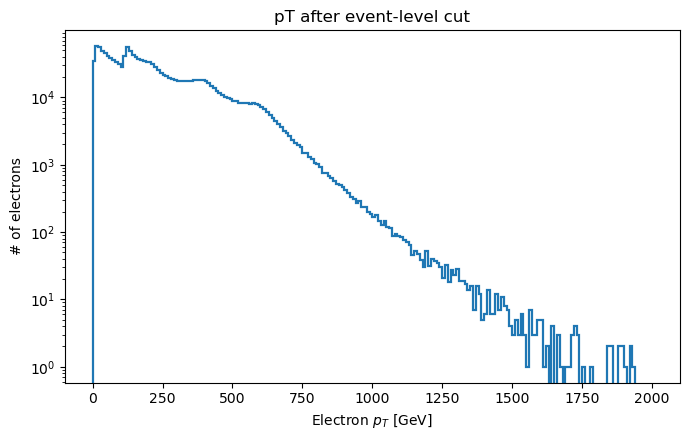

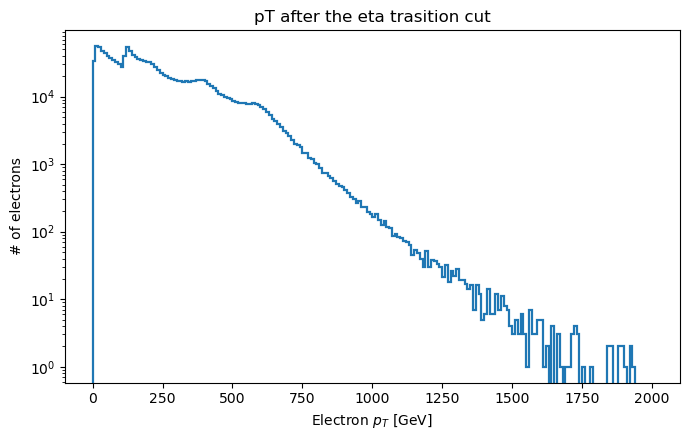

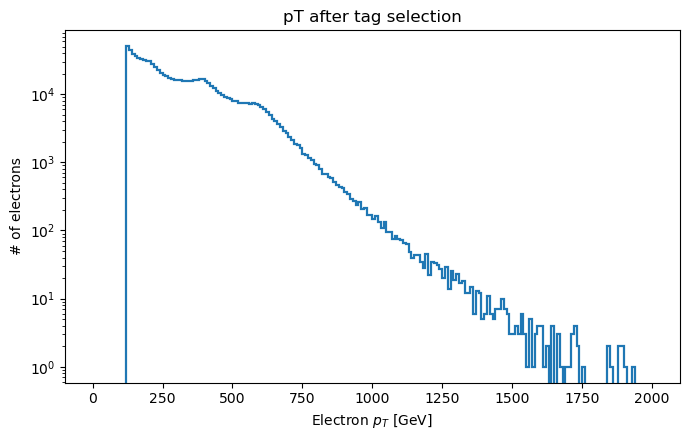

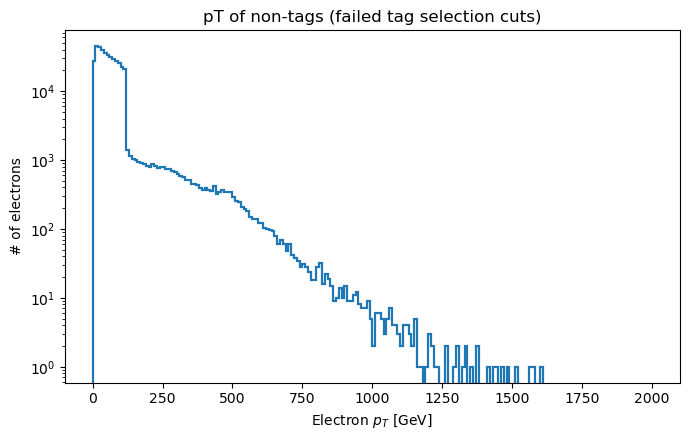

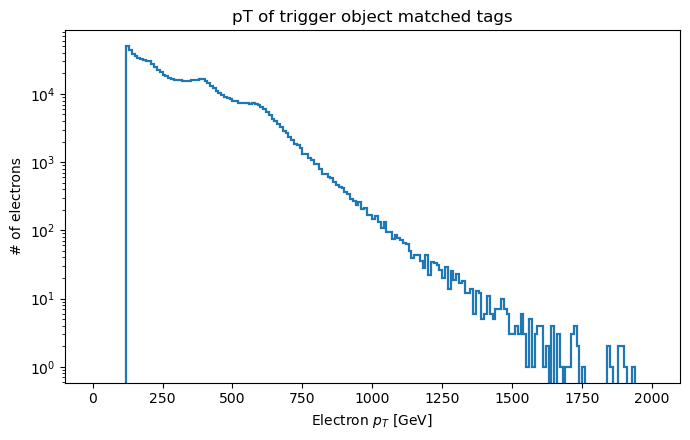

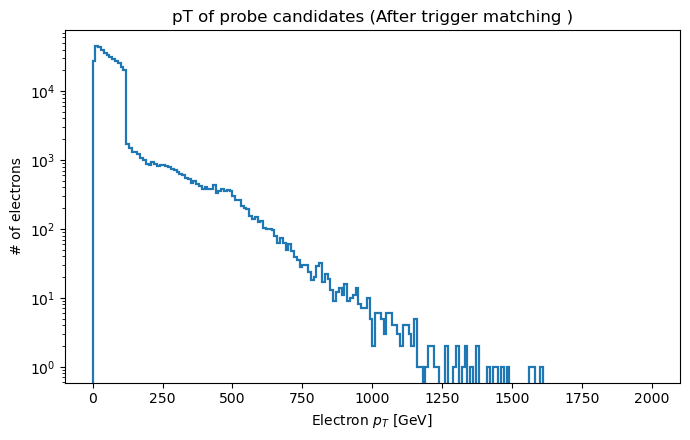

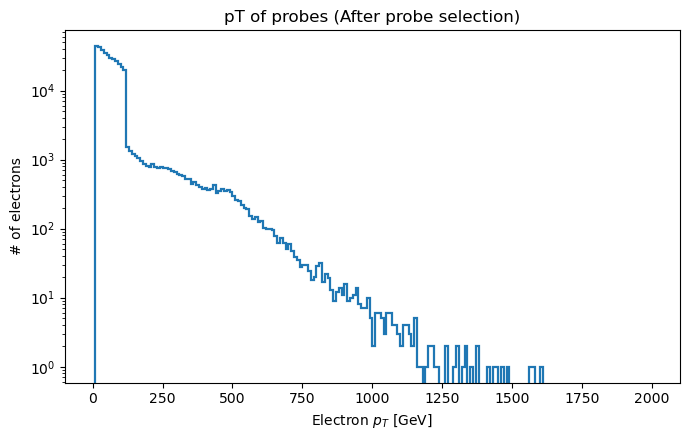

In [38]:
#pt_event_check = ak.to_numpy(ak.flatten(ds["event_check"].pt,    axis=None)) # no cut
pt_ele2_check = ak.to_numpy(ak.flatten(ds["ele2_check"].pt,    axis=None))  #After event level cut
pt_ele2_after_eta_trasition_cut_check = ak.to_numpy(ak.flatten(ds["ele2_after_eta_trasition_cut_check"].pt,    axis=None))
pt_e_tag_check = ak.to_numpy(ak.flatten(ds["e_tag_check"].pt,    axis=None))  #After general tag selection
pt_not_tag_e_tagcut_check = ak.to_numpy(ak.flatten(ds["not_tag_e_tagcut_check"].pt,    axis=None))  #After general tag selection
pt_e_tag_matched_check = ak.to_numpy(ak.flatten(ds["e_tag_matched_check"].pt,    axis=None))  #After trigger matching 
pt_probe_cand_check = ak.to_numpy(ak.flatten(ds["probe_cand_check"].pt,    axis=None))  #After trigger matching 
pt_probe_check = ak.to_numpy(ak.flatten(ds["probe_check"].pt,    axis=None))  #After probe selection

import numpy as np
import matplotlib.pyplot as plt

bins = np.linspace(0, 2000, 201)  

def plot_pt(arr, title, bins=bins, logy=True):
    plt.figure(figsize=(7,4.5))
    plt.hist(arr, bins=bins, histtype="step", linewidth=1.6)
    plt.xlabel("Electron $p_T$ [GeV]")
    plt.ylabel("# of electrons")
    plt.title(title)
    if logy:
        plt.yscale("log")
    plt.tight_layout()
    plt.show()

#plot_pt(pt_event_check,             "pT for all event")
plot_pt(pt_ele2_check,             "pT after event-level cut")
plot_pt(pt_ele2_after_eta_trasition_cut_check, "pT after the eta trasition cut")
plot_pt(pt_e_tag_check,            "pT after tag selection")
plot_pt(pt_not_tag_e_tagcut_check, "pT of non-tags (failed tag selection cuts)")
plot_pt(pt_e_tag_matched_check,    "pT of trigger object matched tags")
plot_pt(pt_probe_cand_check,       "pT of probe candidates (After trigger matching )")
plot_pt(pt_probe_check,            "pT of probes (After probe selection)")




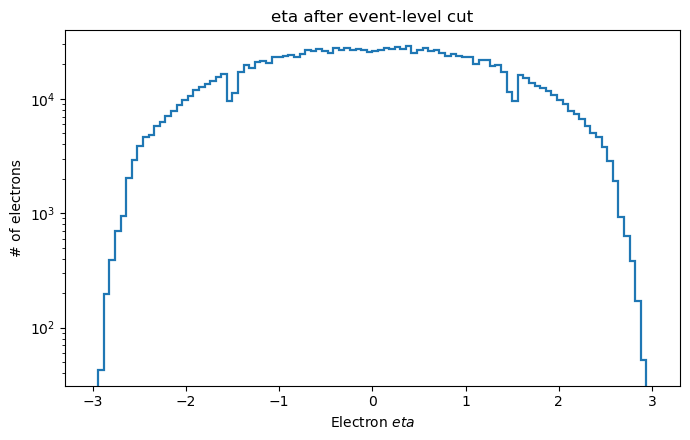

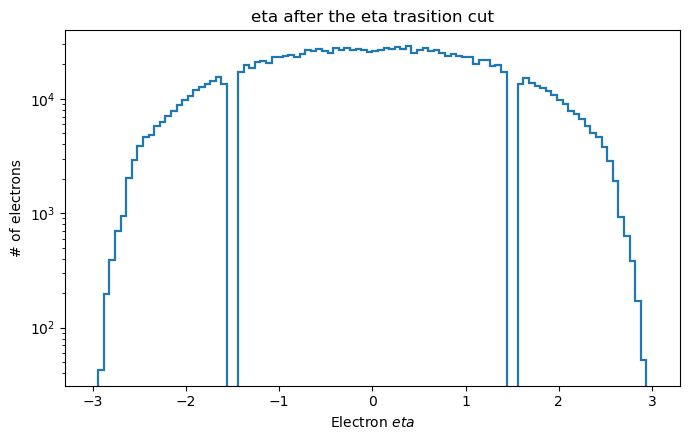

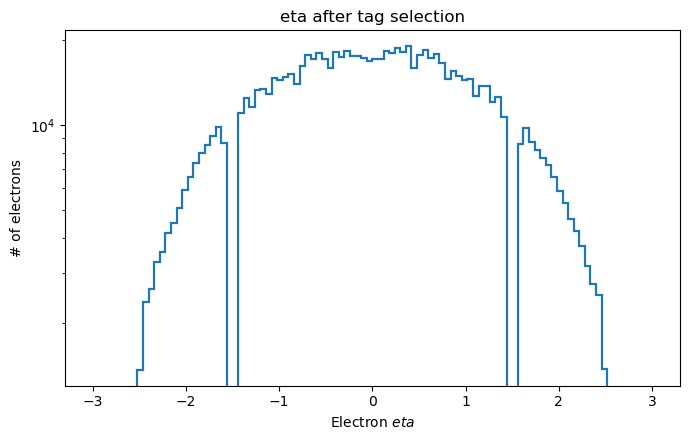

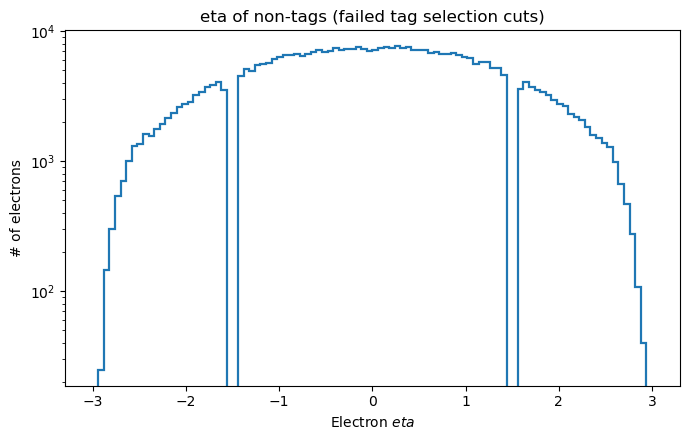

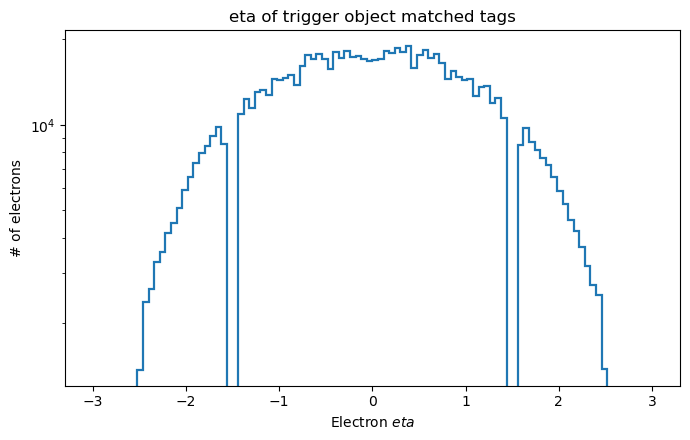

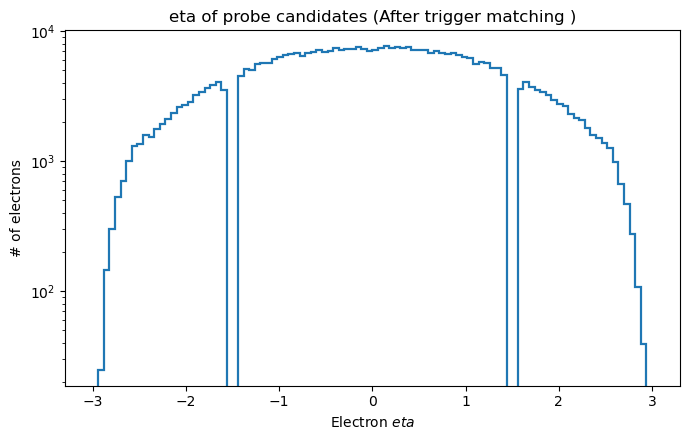

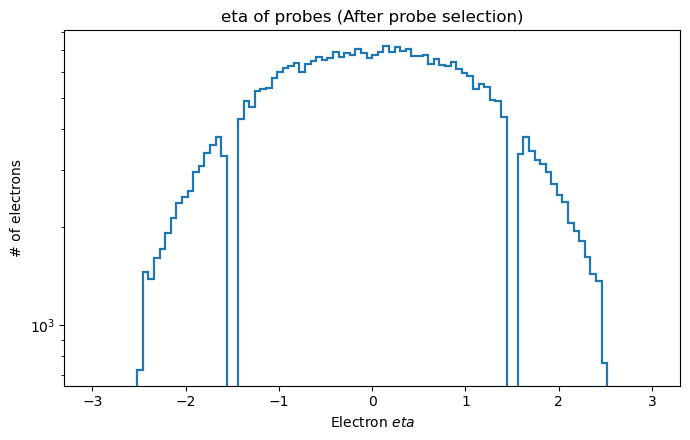

In [39]:
#eta_event_check = ak.to_numpy(ak.flatten(ds["event_check"].superclusterEta,    axis=None))
eta_ele2_check = ak.to_numpy(ak.flatten(ds["ele2_check"].superclusterEta,    axis=None))  #After event level cut
eta_ele2_after_eta_trasition_cut_check = ak.to_numpy(ak.flatten(ds["ele2_after_eta_trasition_cut_check"].superclusterEta,    axis=None))
eta_e_tag_check = ak.to_numpy(ak.flatten(ds["e_tag_check"].superclusterEta,    axis=None))  #After general tag selection
eta_not_tag_e_tagcut_check = ak.to_numpy(ak.flatten(ds["not_tag_e_tagcut_check"].superclusterEta,    axis=None))  #After general tag selection
eta_e_tag_matched_check = ak.to_numpy(ak.flatten(ds["e_tag_matched_check"].superclusterEta,    axis=None))  #After trigger matching 
eta_probe_cand_check = ak.to_numpy(ak.flatten(ds["probe_cand_check"].superclusterEta,    axis=None))  #After trigger matching 
eta_probe_check = ak.to_numpy(ak.flatten(ds["probe_check"].superclusterEta,    axis=None))  #After probe selection

import numpy as np
import matplotlib.pyplot as plt

bins = np.linspace(-3, 3, 101)  

def plot_pt(arr, title, bins=bins, logy=True):
    plt.figure(figsize=(7,4.5))
    plt.hist(arr, bins=bins, histtype="step", linewidth=1.6)
    plt.xlabel("Electron $eta$")
    plt.ylabel("# of electrons")
    plt.title(title)
    if logy:
        plt.yscale("log")
    plt.tight_layout()
    plt.show()

#plot_pt(eta_event_check,             "eta for all event")
plot_pt(eta_ele2_check,             "eta after event-level cut")
plot_pt(eta_ele2_after_eta_trasition_cut_check, "eta after the eta trasition cut")
plot_pt(eta_e_tag_check,            "eta after tag selection")
plot_pt(eta_not_tag_e_tagcut_check, "eta of non-tags (failed tag selection cuts)")
plot_pt(eta_e_tag_matched_check,    "eta of trigger object matched tags")
plot_pt(eta_probe_cand_check,       "eta of probe candidates (After trigger matching )")
plot_pt(eta_probe_check,            "eta of probes (After probe selection)")




In [40]:
#Flatten the arrays first (original:[event][tag][what we want]; now:[.,.,.,.])
q_tag    = ak.to_numpy(ak.flatten(ds["tags"].charge,   axis=None))
q_probe  = ak.to_numpy(ak.flatten(ds["probes"].charge, axis=None))
pt_probe = ak.to_numpy(ak.flatten(ds["probes"].pt,    axis=None))
eta_probe = ak.to_numpy(ak.flatten(ds["probes"].superclusterEta,    axis=None))

# Masks
m_pp = (q_tag > 0) & (q_probe > 0)
m_mm = (q_tag < 0) & (q_probe < 0)
m_pm = (q_tag * q_probe) < 0

# Totals
n_pp = int(np.sum(m_pp))
n_mm = int(np.sum(m_mm))
n_pm = int(np.sum(m_pm))

print("++ rows:", n_pp)
print("-- rows:", n_mm)
print("+- rows:", n_pm)

++ rows: 3066
-- rows: 2838
+- rows: 326003


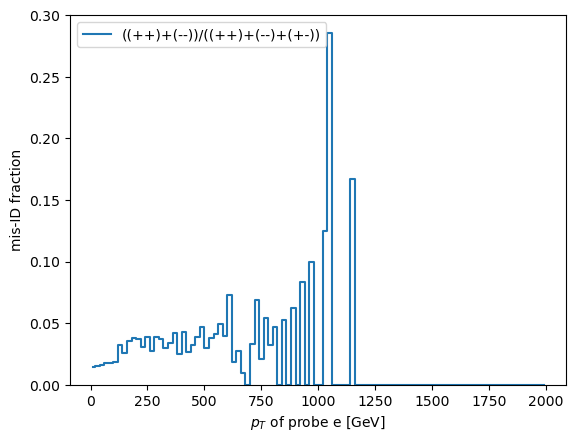

In [41]:
#factor vs. pT
import matplotlib.pyplot as plt

cut_pp = (q_tag > 0) & (q_probe > 0)
cut_mm = (q_tag < 0) & (q_probe < 0)
cut_pm = ((q_tag > 0) & (q_probe < 0)) | ((q_tag < 0) & (q_probe > 0)) 
bins_pt = np.linspace(0, 2000, 101)
centers_pt = 0.5 * (bins_pt[1:] + bins_pt[:-1])


pp_pt, _ = np.histogram(pt_probe[cut_pp], bins=bins_pt)
mm_pt, _ = np.histogram(pt_probe[cut_mm], bins=bins_pt)
pm_pt, _ = np.histogram(pt_probe[cut_pm], bins=bins_pt)


same_pt = pp_pt + mm_pt
tot_pt  = same_pt + pm_pt
ratio_pt = np.divide(same_pt, tot_pt, out=np.zeros_like(same_pt, dtype=float), where=tot_pt > 0)

plt.figure()
plt.step(centers_pt, ratio_pt, where="mid", label="((++)+(--))/((++)+(--)+(+-))")
plt.ylim(0, 0.3)
plt.xlabel(r"$p_T$ of probe e [GeV]")   
plt.ylabel("mis-ID fraction")
#plt.title("Charge mis-ID vs probe $p_T$")
plt.legend()
plt.show()
#note that the y axis is from 0-0.3



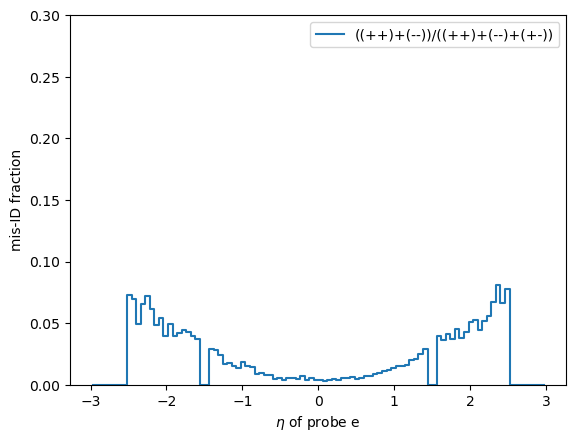

In [42]:
# factor vs. eta
bins_eta = np.linspace(-3, 3, 101)
centers_eta = 0.5 * (bins_eta[1:] + bins_eta[:-1])


pp_eta, _ = np.histogram(eta_probe[cut_pp], bins=bins_eta)
mm_eta, _ = np.histogram(eta_probe[cut_mm], bins=bins_eta)
pm_eta, _ = np.histogram(eta_probe[cut_pm], bins=bins_eta)

same_eta = pp_eta + mm_eta
tot_eta  = same_eta + pm_eta
ratio_eta = np.divide(same_eta, tot_eta, out=np.zeros_like(same_eta, dtype=float), where=tot_eta > 0)

plt.figure()
plt.step(centers_eta, ratio_eta, where="mid", label="((++)+(--))/((++)+(--)+(+-))")
plt.ylim(0, 0.3)
plt.xlabel(r"$\eta$ of probe e")   
plt.ylabel("mis-ID fraction")
plt.legend()
plt.show()


<>:22: SyntaxWarning: invalid escape sequence '\e'
<>:22: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_392/445856237.py:22: SyntaxWarning: invalid escape sequence '\e'
  plt.title("Probe $\eta$ distribution")


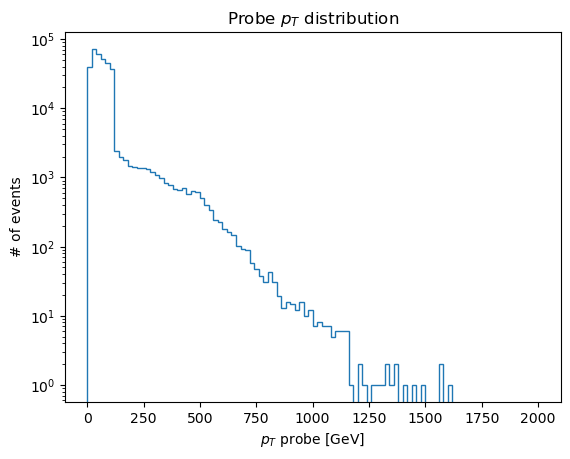

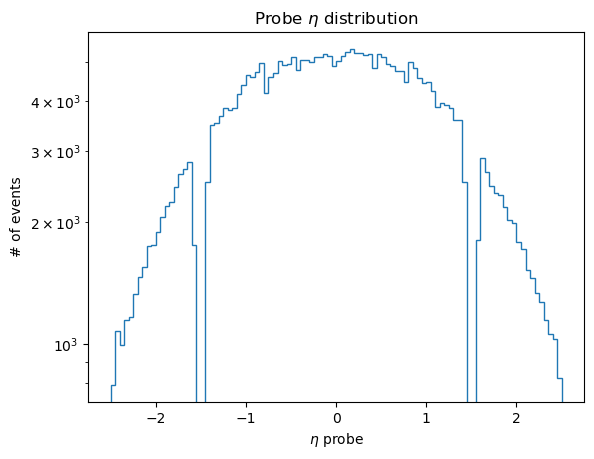

In [43]:
# check pT and eta distribution of the probe e
import numpy as np
import matplotlib.pyplot as plt

bins_pt_check = np.linspace(0, 2000, 101)  

plt.figure()
plt.hist(pt_probe, bins=bins_pt_check, histtype="step")
plt.xlabel(r"$p_T$ probe [GeV]")
plt.ylabel("# of events")
plt.yscale("log")
plt.title("Probe $p_T$ distribution")
plt.show()


bins_eta_check = np.linspace(-2.5, 2.5, 101)
plt.figure()
plt.hist(eta_probe, bins=bins_eta_check, histtype="step")
plt.xlabel(r"$\eta$ probe")
plt.ylabel("# of events")
plt.yscale("log")
plt.title("Probe $\eta$ distribution")
plt.show()


In [44]:
# calculate epsilon_2: (++)/((++)+(--))

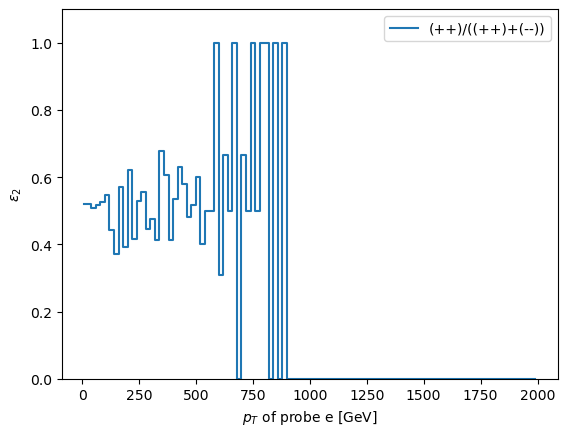

In [51]:
#epsilon_2 vs. pT
bins_pt = np.linspace(0, 2000, 101)
centers_pt = 0.5 * (bins_pt[1:] + bins_pt[:-1])

eta2_ratio_pt = np.divide(pp_pt, same_pt, out=np.zeros_like(pp_pt, dtype=float), where=same_pt > 0)

plt.figure()
plt.step(centers_pt, eta2_ratio_pt, where="mid", label="(++)/((++)+(--))")
plt.ylim(0, 1.1)
plt.xlabel(r"$p_T$ of probe e [GeV]")   
plt.ylabel(r"$\epsilon_2$")
plt.legend()
plt.show()
#note that the y axis is from 0-0.3



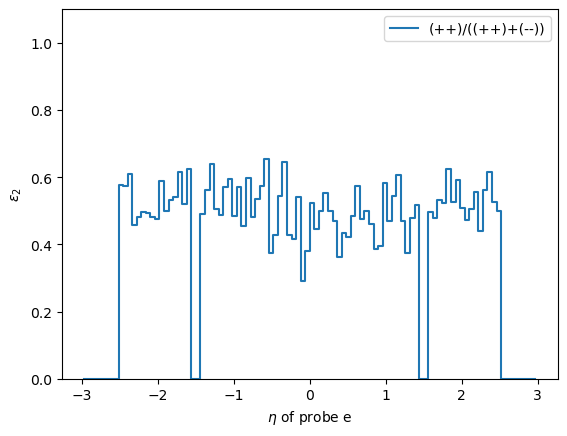

In [52]:
#epsilon_2 vs. eta
bins_eta = np.linspace(-3, 3, 101)
centers_eta = 0.5 * (bins_eta[1:] + bins_eta[:-1])

ratio_eta = np.divide(pp_eta, same_eta, out=np.zeros_like(pp_eta, dtype=float), where=same_eta > 0)

plt.figure()
plt.step(centers_eta, ratio_eta, where="mid", label="(++)/((++)+(--))")
plt.ylim(0, 1.1)
plt.xlabel(r"$\eta$ of probe e")   
plt.ylabel(r"$\epsilon_2$")
plt.legend()
plt.show()


In [47]:
# z mass window i choose 70-110
# MC root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J
# each mass point should have roughly around 800000 events

#check invariant mass of the 2e make sure the distribution shape
#all eta cuts are using supercluster eta ###check!
#points with error bar plot for both eta and pT distribution

In [48]:
# seperate barrel and endcap

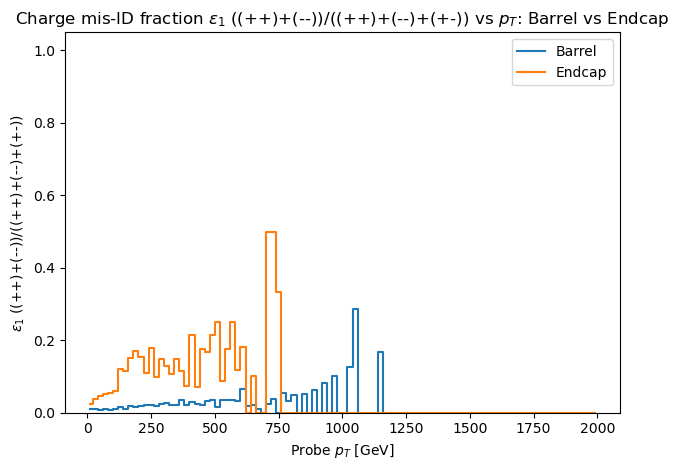

In [54]:
# for epsilon_1 ((++)+(--))/((++)+(--)+(+-))

barrel = (np.abs(eta_probe) <= 1.479)
endcap = (np.abs(eta_probe) > 1.479)
bins_pt = np.linspace(0, 2000, 101)
centers_pt = 0.5 * (bins_pt[1:] + bins_pt[:-1])



# Barrel
ss_barrel_mask   = (m_pp | m_mm) & barrel
tot_barrel_mask  = (m_pp | m_mm | m_pm) & barrel
same_barrel_pt, _ = np.histogram(pt_probe[ss_barrel_mask],  bins=bins_pt)
tot_barrel_pt,  _ = np.histogram(pt_probe[tot_barrel_mask], bins=bins_pt)
ratio_barrel_pt   = np.divide(same_barrel_pt, tot_barrel_pt,
                              out=np.zeros_like(same_barrel_pt, dtype=float),
                              where=tot_barrel_pt > 0)

# Endcap
ss_endcap_mask   = (m_pp | m_mm) & endcap
tot_endcap_mask  = (m_pp | m_mm | m_pm) & endcap
same_endcap_pt, _ = np.histogram(pt_probe[ss_endcap_mask],  bins=bins_pt)
tot_endcap_pt,  _ = np.histogram(pt_probe[tot_endcap_mask], bins=bins_pt)
ratio_endcap_pt   = np.divide(same_endcap_pt, tot_endcap_pt,
                              out=np.zeros_like(same_endcap_pt, dtype=float),
                              where=tot_endcap_pt > 0)

# Plot
plt.figure()
plt.step(centers_pt, ratio_barrel_pt, where="mid", label='Barrel')
plt.step(centers_pt, ratio_endcap_pt, where="mid", label='Endcap')
# plt.step(centers_pt, ratio_pt, where="mid", label='All', linestyle='--')
plt.ylim(0, 1.05)
plt.xlabel(r"Probe $p_T$ [GeV]")
plt.ylabel(r"$\epsilon_1$ ((++)+(--))/((++)+(--)+(+-))")
plt.title(r"Charge mis-ID fraction $\epsilon_1$ ((++)+(--))/((++)+(--)+(+-)) vs $p_T$: Barrel vs Endcap")
plt.legend()
plt.tight_layout()
plt.show()





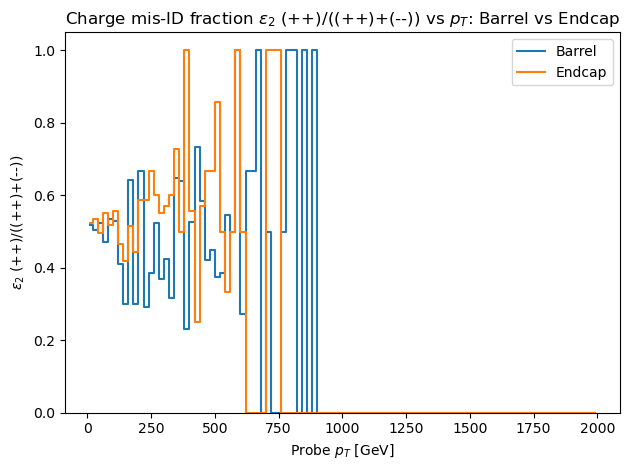

In [56]:
# for epsilon_2 (++)/((++)+(--))



bins_pt = np.linspace(0, 2000, 101)
centers_pt = 0.5 * (bins_pt[1:] + bins_pt[:-1])



# Barrel
pp_barrel_mask   = m_pp & barrel

pp_barrel_pt, _ = np.histogram(pt_probe[pp_barrel_mask],  bins=bins_pt)
epsilon_2_barrel_pt   = np.divide(pp_barrel_pt, same_barrel_pt,
                              out=np.zeros_like(pp_barrel_pt, dtype=float),
                              where=same_barrel_pt > 0)

# Endcap
pp_endcap_mask   = m_pp & endcap
pp_endcap_pt, _ = np.histogram(pt_probe[pp_endcap_mask],  bins=bins_pt)

epsilon_2_endcap_pt   = np.divide(pp_endcap_pt, same_endcap_pt,
                              out=np.zeros_like(pp_endcap_pt, dtype=float),
                              where=same_endcap_pt > 0)

# Plot
plt.figure()
plt.step(centers_pt, epsilon_2_barrel_pt, where="mid", label='Barrel')
plt.step(centers_pt, epsilon_2_endcap_pt, where="mid", label='Endcap')
# plt.step(centers_pt, ratio_pt, where="mid", label='All', linestyle='--')
plt.ylim(0, 1.05)
plt.xlabel(r"Probe $p_T$ [GeV]")
plt.ylabel(r"$\epsilon_2$ (++)/((++)+(--))")
plt.title(r"Charge mis-ID fraction $\epsilon_2$ (++)/((++)+(--)) vs $p_T$: Barrel vs Endcap")
plt.legend()
plt.tight_layout()
plt.show()



